<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
#from torchsummary import summary

import os
#from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [2]:
# @title Data Loading
if os.path.isdir('./Training'):
    !rm ./Training/ -d -r
    !rm ./Testing/ -d -r
    !rm ./Validation/ -d -r
try:
    from google.colab import files
    if not os.path.isfile('./.kaggle/kaggle.json'):
        print('Upload kaggle.json account information to download the dataset:')
        files.upload()
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json
except:
    print('Colab initialization failed')
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force
!unzip -q brain-tumor-mri-dataset.zip 

Colab initialization failed
 98%|███████████████████████████████████████ | 145M/149M [00:03<00:00, 45.3MB/s]
100%|████████████████████████████████████████| 149M/149M [00:03<00:00, 43.4MB/s]


In [3]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [4]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
Classifier.to('cuda')
#summary(Classifier, (3, 256, 256))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

0 tensor([0, 1, 2, 0, 1, 2, 3, 0, 3, 0, 3, 3, 3, 3, 1, 0, 2, 2, 0, 1, 2, 3, 2, 1,
        2, 1, 2, 1, 0, 0, 0, 2])


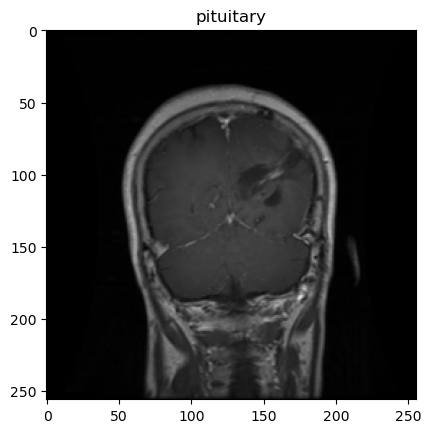

In [5]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=32, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=32, shuffle=True)
classes = os.listdir('./Training/')
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [6]:
# Cross Entropy Loss for categorization
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Classifier.parameters(), lr=0.005, momentum=.5)


def calc_accuracy(prediction, label):
  prediction = torch.argmax(prediction, axis=1)
  return (prediction == label).sum()/len(label) * 100


def one_epoch(epoch_index):
  current_loss = 0
  running_loss = 0
  val_running_loss = 0
  acc = []
  val_acc = []
  optimizer.zero_grad()

  for i, data in enumerate(TrainingLoader):
    inputs, labels = data

    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    outputs = Classifier(inputs)
    acc.append(calc_accuracy(outputs, labels))
    loss = loss_fn(outputs, labels)
    loss.backward()

    optimizer.step()

    current_loss += loss.item()
    running_loss += loss.item()
    if i % 10 == 9:
      print(f'Epoch {epoch_index + 1}, Batch {i + 1}, Loss: {current_loss / 10:.3f}, Running Accuracy {sum(acc)/(i+1)}')
      current_loss = 0.0
    optimizer.zero_grad()

  print(f'Epoch {epoch_index + 1}, Total Loss: {running_loss}, Total Accuracy: {sum(acc)/(i+1)}')
  print('Validating...')
  for i, data in enumerate(ValidationLoader):
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    outputs = Classifier(inputs)
    val_acc.append(calc_accuracy(outputs, labels))
    loss = loss_fn(outputs, labels)
    val_running_loss += loss.item()
  print(f'Epoch{epoch_index + 1}, Validation Loss: {val_running_loss}, Validation Accuracy {sum(val_acc)/(i+1)}')
  return running_loss, sum(acc)/(i+1), val_running_loss, sum(val_acc)/(i+1)

In [ ]:
for i in range(0,100):
  one_epoch(i)

/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Batch 10, Loss: 1.201, Running Accuracy 44.6875
Epoch 1, Batch 20, Loss: 0.718, Running Accuracy 57.8125
Epoch 1, Batch 30, Loss: 0.839, Running Accuracy 61.770835876464844
Epoch 1, Batch 40, Loss: 0.446, Running Accuracy 67.34375
Epoch 1, Batch 50, Loss: 0.421, Running Accuracy 70.9375
Epoch 1, Batch 60, Loss: 0.288, Running Accuracy 74.01042175292969
Epoch 1, Batch 70, Loss: 0.417, Running Accuracy 75.53571319580078
Epoch 1, Batch 80, Loss: 0.380, Running Accuracy 76.8359375
Epoch 1, Batch 90, Loss: 0.344, Running Accuracy 78.19444274902344
Epoch 1, Batch 100, Loss: 0.353, Running Accuracy 79.34375
Epoch 1, Batch 110, Loss: 0.324, Running Accuracy 80.0852279663086
Epoch 1, Batch 120, Loss: 0.312, Running Accuracy 80.85938262939453
Epoch 1, Batch 130, Loss: 0.246, Running Accuracy 81.70673370361328
Epoch 1, Batch 140, Loss: 0.178, Running Accuracy 82.61161041259766
Epoch 1, Total Loss: 66.88047067821026, Total Accuracy: 82.8448257446289
Validating...
